# Summary
Used LGBMClassifier with SMOTE on an imbalanced dataset. Using smote improved the precision, recall, and f1-score of the model significantly.

The rest of the notebook is organized as follows:
1. EDA
2. LGBMCLassifier
3. LGBMClassifier with smote


dataset from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

inspired by https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


show column names and datatypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

check for nulls 

In [4]:
df.isnull().any().sum()

0

Inspect the target column distribution.  
Almost all are labeled 0. This is an example of an imbalanced dataset.

In [5]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Only 0.17% of the labels are 1. This means that even if our model predicted only 0 for the whole dataset, the accuracy would still be 99.8%.  

In [6]:
df['Class'].value_counts()[1]/df['Class'].value_counts().sum()

0.001727485630620034

Strategies to Handle Imbalanced Datasets
To address the challenges posed by imbalanced datasets, consider the following strategies:
1. Resampling Techniques
Oversampling: Increase the number of instances in the minority class by duplicating existing samples or generating synthetic samples (e.g., using SMOTE - Synthetic Minority Over-sampling Technique).
Undersampling: Reduce the number of instances in the majority class to balance the dataset, though this may lead to loss of valuable information.
2. Algorithmic Approaches
Cost-sensitive Learning: Modify algorithms to take misclassification costs into account, giving more weight to the minority class.
Ensemble Methods: Utilize techniques like Random Forests or Gradient Boosting that can handle imbalance better than standard classifiers.
3. Evaluation Metrics
Use Appropriate Metrics: Focus on metrics such as precision, recall, F1-score, and area under the ROC curve (AUC-ROC) instead of accuracy alone.
Confusion Matrix: Analyze the confusion matrix to understand how well your model is performing across different classes.

# Training
Stratified splitting
Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [7]:
X = df.drop('Class', axis=1)
y = df['Class'].to_frame()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
sample_row = X.iloc[0,:].to_dict()

stratify ensures that each class has the same distribution

In [8]:
print(y_train.value_counts())
print(y_valid.value_counts())


Class
0        199020
1           344
Name: count, dtype: int64
Class
0        85295
1          148
Name: count, dtype: int64


# LGBMClassifier
As expected, the accuracy is more than 99%. However, the precision, recall, and f1-score is very low for 1.  
The confusion matrix shows that there is a lot of false-positive and false-negative.

/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.65      0.39       148

    accuracy                           1.00     85443
   macro avg       0.64      0.82      0.70     85443
weighted avg       1.00      1.00      1.00     85443



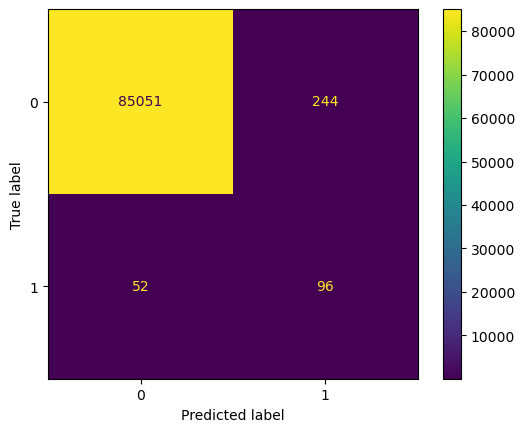

In [9]:
model = LGBMClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(classification_report(y_valid, preds))
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

y_probs = model.predict_proba(X_valid)[:, 1]
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The is_unbalanced parameter of lgbm does not improve the performance.

/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] Unknown parameter: is_unbalanced
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.25      0.64      0.36       148

    accuracy                           1.00     85443
   macro avg       0.62      0.82      0.68     85443
weighted avg       1.00      1.00      1.00     85443



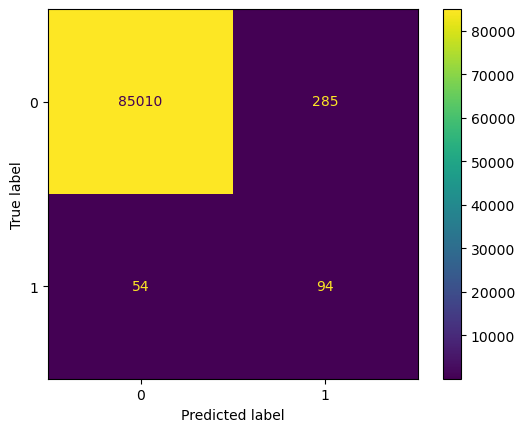

In [15]:
model = LGBMClassifier(is_unbalanced=True)
model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(classification_report(y_valid, preds))
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

ROC Curve: The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. It provides a visual representation of a classifier's performance across all classification thresholds.

AUC (Area Under the Curve): The AUC quantifies the overall ability of the model to discriminate between positive and negative classes. An AUC of 1 indicates perfect classification, while an AUC of 0.5 suggests no discriminative ability (equivalent to random guessing).

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: scale_pos


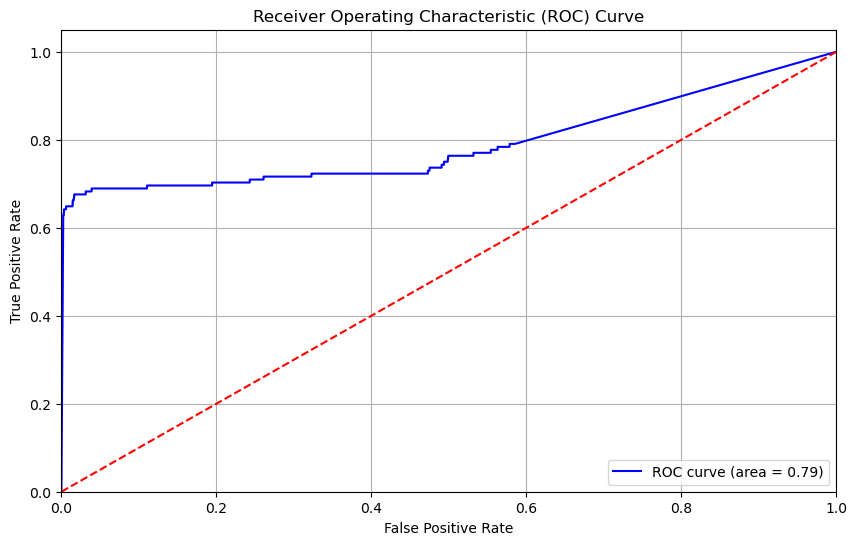

In [20]:
y_probs = model.predict_proba(X_valid)[:, 1]
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# SMOTE

In [11]:
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

After SMOTE, the number of 1 and 0 in the target column is now balanced.

<Axes: ylabel='Class'>

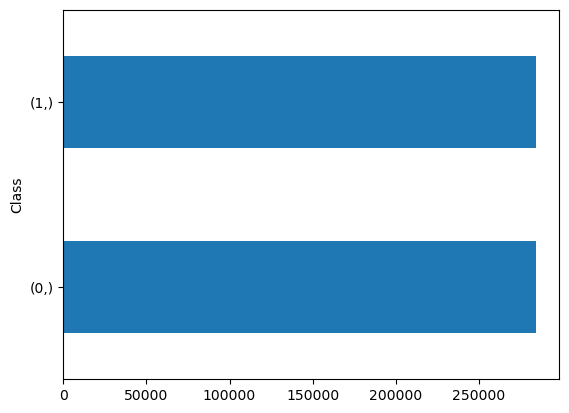

In [12]:
y_resampled.value_counts().plot(kind='barh')

# LGBMClassifier with SMOTE
The accuracy is still over 99%. However, the precision, recall, and f1-score is significantly better for 1.  
The confusion matrix also shows that there are significantly less false positives and false negatives. 

/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 284315, number of negative: 284315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 568630, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.77      0.99      0.86       148

    accuracy                           1.00     85443
   macro avg       0.88      1.00      0.93     85443
weighted avg       1.00      1.00      1.00     85443



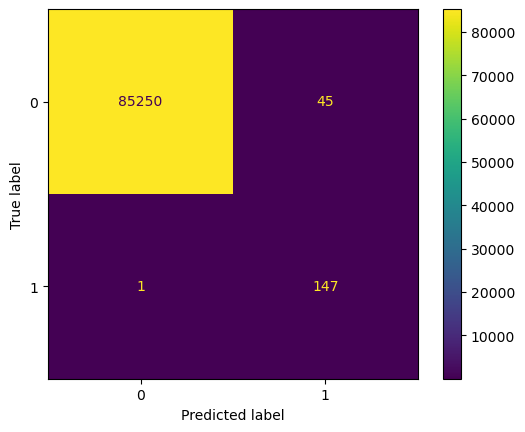

In [13]:
model = LGBMClassifier()
model.fit(X_resampled, y_resampled)
preds = model.predict(X_valid)

print(classification_report(y_valid, preds))
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

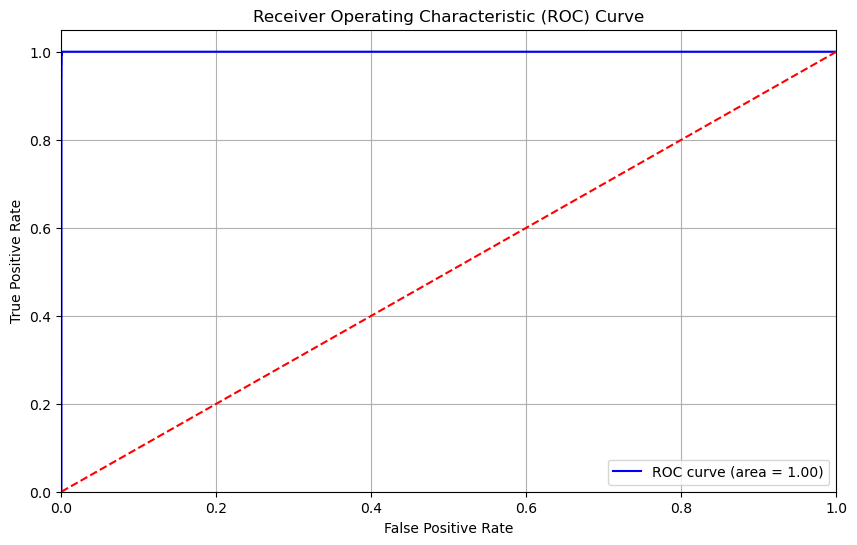

In [14]:
y_probs = model.predict_proba(X_valid)[:, 1]
y_probs = model.predict_proba(X_valid)[:, 1]
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()